# 📊 Step 1: Data Loader & Preprocessing (데이터 로드 및 전처리)

## 🎯 Objective (목표)
This notebook serves as the **Data Ingestion** layer for the AI Risk Engine pipeline. 
이 노트북은 AI 리스크 엔진 파이프라인의 **데이터 수집(Data Ingestion)** 단계를 담당합니다.

It performs the following critical tasks (다음과 같은 핵심 작업을 수행합니다):
1. **Download**: Fetches historical S&P 500 (SPY) price data from Yahoo Finance. (Yahoo Finance에서 S&P 500 과거 데이터 다운로드)
2. **Preprocess**: Calculates daily log returns and cleans missing data. (일별 로그 수익률 계산 및 결측치 제거)
3. **Export**: Saves the clean dataset to `data/processed/spy_returns.csv` for downstream models. (정제된 데이터를 `data/processed/`에 저장하여 후속 모델에서 사용)

> **Why separate this? (왜 분리했나요?)**  
> By isolating data ingestion, we ensure that all subsequent AI models trained in `02` and `03` share the exact same consistent dataset, preventing data leakage or version mismatch.
> 데이터 수집 과정을 분리함으로써, `02`번과 `03`번에서 학습되는 모든 AI 모델이 **동일한 데이터셋**을 사용하도록 보장합니다.

In [1]:
# =============================================================================
# 1. Environment Setup (환경 설정)
# =============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Define paths (경로 정의)
DATA_DIR = '../data/processed'
os.makedirs(DATA_DIR, exist_ok=True)
OUTPUT_PATH = os.path.join(DATA_DIR, 'spy_returns.csv')

print(f"📂 Data Directory: {os.path.abspath(DATA_DIR)}")

📂 Data Directory: c:\Users\Jun\Desktop\Thesis\Projects\Neural_Path_Integral\data\processed


## 2. Download Market Data (SPY) (시장 데이터 다운로드)

In [2]:
# =============================================================================
# 2. Fetch Data from Yahoo Finance (Yahoo Finance에서 데이터 가져오기)
# =============================================================================
START_DATE = '2005-01-01'  # 2008 Financial Crisis included (2008 금융위기 포함)
END_DATE = datetime.today().strftime('%Y-%m-%d')
TICKER = 'SPY'

print(f"⬇️ Downloading {TICKER} data from {START_DATE} to {END_DATE}...")

try:
    import yfinance as yf
    df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
    
    if df.empty:
        raise ValueError("Downloaded dataframe is empty.")
        
    # Standardize column names (컬럼명 표준화)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
        
    print(f"✅ Successfully downloaded {len(df)} trading days.")

except Exception as e:
    print(f"⚠️ Download failed: {e}")
    print("🔄 Generating Synthetic SPY Data (Fallback Mode)...")
    
    # Synthetic Data Generation (합성 데이터 생성 - Fallback)
    np.random.seed(42)
    dates = pd.date_range(start=START_DATE, end=END_DATE, freq='B')
    n_days = len(dates)
    
    # GBM Parameters (GBM 파라미터)
    mu = 0.0003
    sigma = 0.012
    returns = np.random.normal(mu, sigma, n_days)
    
    # Add 'Financial Crisis' Jumps (금융위기 점프 추가)
    n_crashes = 5
    crash_indices = np.random.choice(n_days, size=50, replace=False)
    returns[crash_indices] = np.random.normal(-0.03, 0.02, 50)
    
    prices = 100 * np.cumprod(1 + returns)
    df = pd.DataFrame({'Close': prices, 'Adj Close': prices}, index=dates)
    
print(df.tail())

⬇️ Downloading SPY data from 2005-01-01 to 2026-01-05...


C:\Users\Jun\AppData\Local\Temp\ipykernel_14088\415080662.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


✅ Successfully downloaded 5284 trading days.
Price            Close        High         Low        Open    Volume
Date                                                                
2025-12-26  690.309998  691.659973  689.270020  690.640015  41613300
2025-12-29  687.849976  689.200012  686.070007  687.539978  62559500
2025-12-30  687.010010  688.559998  686.580017  687.450012  47160700
2025-12-31  681.919983  687.359985  681.710022  687.140015  74144800
2026-01-02  683.169983  686.869995  679.820007  685.710022  89310400


## 3. Preprocessing (Return Calculation) (전처리: 수익률 계산)

In [3]:
# =============================================================================
# 3. Calculate Returns & Clean (수익률 계산 및 정제)
# =============================================================================

# Use Adjusted Close to account for dividends/splits (수정 주가 사용)
price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
df_clean = pd.DataFrame()
df_clean['Close'] = df[price_col]

# Log Returns: ln(S_t / S_{t-1}) (로그 수익률)
# Preferred for Neural SDEs as they are additive (Neural SDE 학습에 유리함)
df_clean['Returns'] = np.log(df_clean['Close'] / df_clean['Close'].shift(1))

# Drop NaN values (first row) (결측치 제거)
df_clean = df_clean.dropna()

print(f"📊 Processed Data Shape: {df_clean.shape}")
print(f"   Mean Return (평균 수익률): {df_clean['Returns'].mean():.6f}")
print(f"   Volatility (변동성):  {df_clean['Returns'].std():.6f}")

📊 Processed Data Shape: (5283, 2)
   Mean Return (평균 수익률): 0.000402
   Volatility (변동성):  0.012011


## 4. Visualization & Export (시각화 및 내보내기)

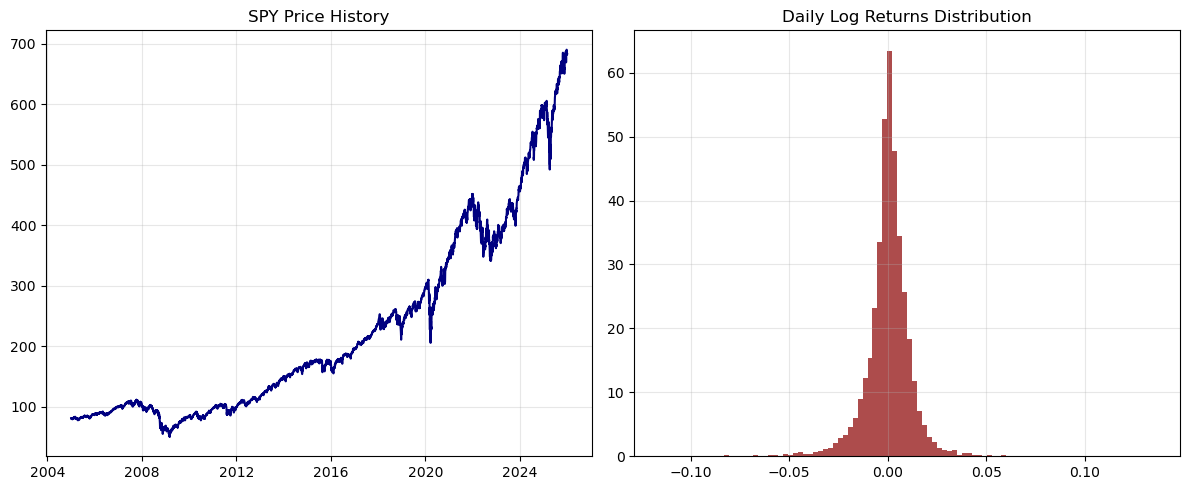

✅ Data successfully saved to: ../data/processed\spy_returns.csv
   Next Step: Proceed to '02_Neural_SDE_Training.ipynb'


In [5]:
# =============================================================================
# 4. Visualize & Save (시각화 및 저장)
# =============================================================================

# Plot Returns Distribution (수익률 분포 시각화)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df_clean.index, df_clean['Close'], color='navy')
plt.title(f'{TICKER} Price History')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_clean['Returns'], bins=100, color='darkred', alpha=0.7, density=True)
plt.title('Daily Log Returns Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Export to CSV (CSV 저장)
df_clean.to_csv(OUTPUT_PATH)
print("="*60)
print(f"✅ Data successfully saved to: {OUTPUT_PATH}")
print("   Next Step: Proceed to '02_Neural_SDE_Training.ipynb'")
print("="*60)